In this notebook, I used the bootstrap resampling method to give a robust estimate of the global spin of the VLBI CRF.

In [1]:
import matplotlib.pyplot as plt
# from matplotlib.ticker import MultipleLocator
import numpy as np
np.random.seed(28)

# Used for ECDF estimate
import statsmodels.api as sm
from astropy.table import Table, join
from astropy.stats import bootstrap

from tool_func import vsh_fit_for_pm

Load the table for fitted APM and convert the unit of APM.

In [2]:
apm_tab = Table.read("../data/ts_nju_pm_fit_10sigma-10step.dat", format="ascii.csv")

# convert mas/yr into muas/yr
apm_tab["pmra"] = apm_tab["pmra"] * 1e3
apm_tab["pmra_err"] = apm_tab["pmra_err"] * 1e3
apm_tab["pmdec"] = apm_tab["pmdec"] * 1e3
apm_tab["pmdec_err"] = apm_tab["pmdec_err"] * 1e3

ICRF3 defining source table.

In [3]:
icrf3_def = Table.read("../data/icrf3sx-def-sou.txt", format="ascii")

Remove sources without apparant proper motion estimate.

In [4]:
mask = apm_tab["num_cln"] >= 5
apm_tab = apm_tab[mask]

apm_def = join(icrf3_def, apm_tab, keys="iers_name")

Generate an array of index for the bootstrap resampling.

In [5]:
idx = np.arange(len(apm_def), dtype=int)

Create 100 arrays of index for resampled data.

In [6]:
sample_num = 1000

resample_idx = bootstrap(idx, sample_num)

Create empty arrays for store the results.

In [7]:
resample_wx = np.zeros(sample_num)
resample_wy = np.zeros(sample_num)
resample_wz = np.zeros(sample_num)
resample_w = np.zeros(sample_num)
resample_ra = np.zeros(sample_num)
resample_dec = np.zeros(sample_num)

Do the LSQ fit.

In [8]:
for i, new_idx in enumerate(resample_idx):

    new_table = apm_def[np.array(new_idx, dtype=int)]

    pmt, sig, output = vsh_fit_for_pm(new_table)

    resample_wx[i] = pmt[0]
    resample_wy[i] = pmt[1]
    resample_wz[i] = pmt[2]
    
    resample_w[i] = pmt[3]
    resample_ra[i] = output["R_ra"]
    resample_dec[i] = output["R_dec"]

Assume that $\omega_x$, $\omega_y$, $\omega_z$, and $\omega$ follows a Gaussian distribution, I estimate the mean and sigma.

In [9]:
from scipy.stats import norm

In [10]:
mu_wx, std_wx = norm.fit(resample_wx)
mu_wy, std_wy = norm.fit(resample_wy)
mu_wz, std_wz = norm.fit(resample_wz)

mu_w, std_w = norm.fit(resample_w)
mu_ra, std_ra = norm.fit(resample_ra)
mu_dec, std_dec = norm.fit(resample_dec)

In [11]:
# Distribution
rvs_wx = norm(mu_wx, std_wx)
rvs_wy = norm(mu_wy, std_wy)
rvs_wz = norm(mu_wz, std_wz)

rvs_w = norm(mu_w, std_w)
rvs_ra = norm(mu_ra, std_ra)
rvs_dec = norm(mu_dec, std_dec)

Plot the distribution of $\omega_x$, $\omega_y$, $\omega_z$, and $\omega$.

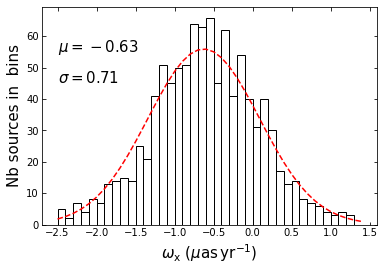

In [12]:
bin_size = 0.1
bin_array = np.arange(-2.5, 1.5, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wx,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_wx.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(-2.5, 55, "$\mu={:+.2f}$".format(mu_wx), fontsize=15)
ax.text(-2.5, 45, "$\sigma={:.2f}$".format(std_wx), fontsize=15)

ax.set_xlabel("$\\omega_{\\rm x}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout
plt.savefig("../plots/spin-x-from-resampled-apm.eps")

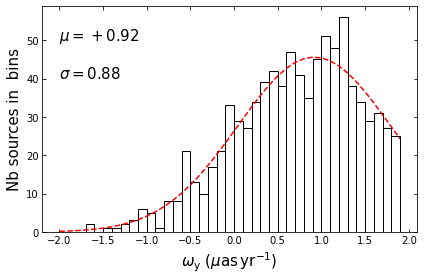

In [13]:
bin_size = 0.1
bin_array = np.arange(-2.0, 2.0, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wy,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_wy.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(-2., 50, "$\mu={:+.2f}$".format(mu_wy), fontsize=15)
ax.text(-2., 40, "$\sigma={:.2f}$".format(std_wy), fontsize=15)

ax.set_xlabel("$\\omega_{\\rm y}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()
plt.savefig("../plots/spin-y-from-resampled-apm.eps")

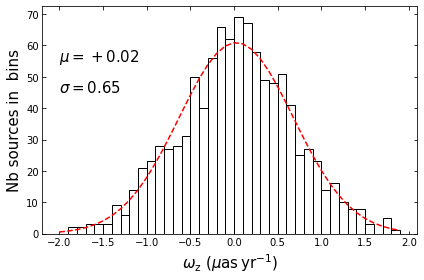

In [14]:
bin_size = 0.1
bin_array = np.arange(-2.0, 2.0, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wz,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_wz.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(-2., 55, "$\mu={:+.2f}$".format(mu_wz), fontsize=15)
ax.text(-2., 45, "$\sigma={:.2f}$".format(std_wz), fontsize=15)

ax.set_xlabel("$\\omega_{\\rm z}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()
plt.savefig("../plots/spin-z-from-resampled-apm.eps")

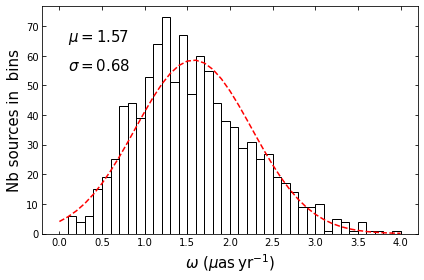

In [15]:
bin_size = 0.1
bin_array = np.arange(0, 4.1, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_w,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_w.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(0.1, 65, "$\mu={:.2f}$".format(mu_w), fontsize=15)
ax.text(0.1, 55, "$\sigma={:.2f}$".format(std_w), fontsize=15)

ax.set_xlabel("$\\omega$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

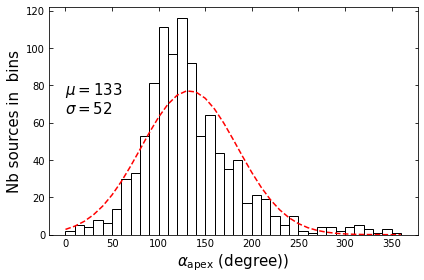

In [16]:
bin_size = 10
bin_array = np.arange(0, 361, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_ra,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_ra.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(0, 75, "$\mu={:.0f}$".format(mu_ra), fontsize=15)
ax.text(0, 65, "$\sigma={:.0f}$".format(std_ra), fontsize=15)

ax.set_xlabel("$\\alpha_{\\rm apex}$ (degree))", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

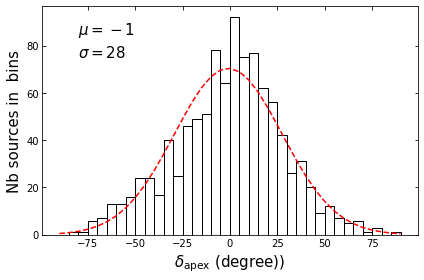

In [17]:
bin_size = 5
bin_array = np.arange(-90, 91, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_dec,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_dec.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(-80, 85, "$\mu={:-.0f}$".format(mu_dec), fontsize=15)
ax.text(-80, 75, "$\sigma={:.0f}$".format(std_dec), fontsize=15)

ax.set_xlabel("$\\delta_{\\rm apex}$ (degree))", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

All these is done for the ICRF3 defining source subset. 

And I repeat this procedure to the all sources with the APM estimates.

Generate an array of index for the bootstrap resampling.

In [18]:
idx = np.arange(len(apm_tab), dtype=int)

Create 100 arrays of index for resampled data.

In [19]:
sample_num = 1000

resample_idx = bootstrap(idx, sample_num)

Create empty arrays for store the results.

In [20]:
resample_wx = np.zeros(sample_num)
resample_wy = np.zeros(sample_num)
resample_wz = np.zeros(sample_num)
resample_w = np.zeros(sample_num)
resample_ra = np.zeros(sample_num)
resample_dec = np.zeros(sample_num)

Do the LSQ fit.

In [21]:
for i, new_idx in enumerate(resample_idx):

    new_table = apm_tab[np.array(new_idx, dtype=int)]

    pmt, sig, output = vsh_fit_for_pm(new_table)

    resample_wx[i] = pmt[0]
    resample_wy[i] = pmt[1]
    resample_wz[i] = pmt[2]
    
    resample_w[i] = pmt[3]
    resample_ra[i] = output["R_ra"]
    resample_dec[i] = output["R_dec"]

Assume that $\omega_x$, $\omega_y$, $\omega_z$, and $\omega$ follows a Gaussian distribution, I estimate the mean and sigma.

In [22]:
mu_wx, std_wx = norm.fit(resample_wx)
mu_wy, std_wy = norm.fit(resample_wy)
mu_wz, std_wz = norm.fit(resample_wz)

mu_w, std_w = norm.fit(resample_w)
mu_ra, std_ra = norm.fit(resample_ra)
mu_dec, std_dec = norm.fit(resample_dec)

In [23]:
# Distribution
rvs_wx = norm(mu_wx, std_wx)
rvs_wy = norm(mu_wy, std_wy)
rvs_wz = norm(mu_wz, std_wz)

rvs_w = norm(mu_w, std_w)
rvs_ra = norm(mu_ra, std_ra)
rvs_dec = norm(mu_dec, std_dec)

Plot the distribution of $\omega_x$, $\omega_y$, $\omega_z$, and $\omega$.

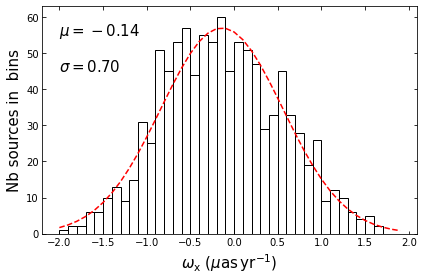

In [24]:
bin_size = 0.1
bin_array = np.arange(-2., 2, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wx,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_wx.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(-2., 55, "$\mu={:+.2f}$".format(mu_wx), fontsize=15)
ax.text(-2., 45, "$\sigma={:.2f}$".format(std_wx), fontsize=15)

ax.set_xlabel("$\\omega_{\\rm x}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

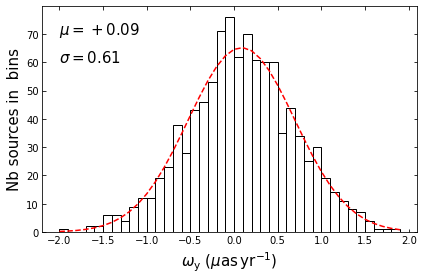

In [25]:
bin_size = 0.1
bin_array = np.arange(-2.0, 2.0, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wy,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_wy.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(-2., 70, "$\mu={:+.2f}$".format(mu_wy), fontsize=15)
ax.text(-2., 60, "$\sigma={:.2f}$".format(std_wy), fontsize=15)

ax.set_xlabel("$\\omega_{\\rm y}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

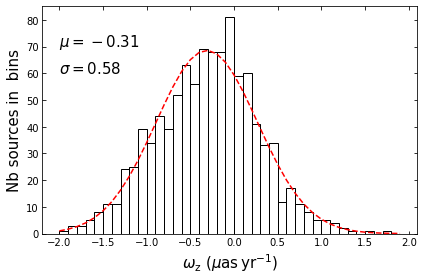

In [26]:
bin_size = 0.1
bin_array = np.arange(-2.0, 2.0, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_wz,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_wz.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(-2., 70, "$\mu={:+.2f}$".format(mu_wz), fontsize=15)
ax.text(-2., 60, "$\sigma={:.2f}$".format(std_wz), fontsize=15)

ax.set_xlabel("$\\omega_{\\rm z}$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

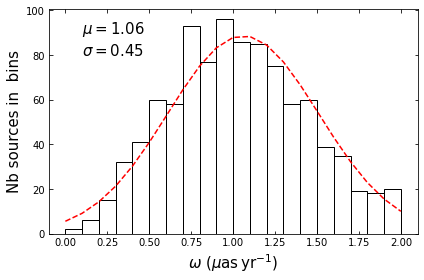

In [27]:
bin_size = 0.1
bin_array = np.arange(0, 2.1, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_w,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_w.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(0.1, 90, "$\mu={:.2f}$".format(mu_w), fontsize=15)
ax.text(0.1, 80, "$\sigma={:.2f}$".format(std_w), fontsize=15)

ax.set_xlabel("$\\omega$ ($\\mu$as$\,$yr$^{-1}$)", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

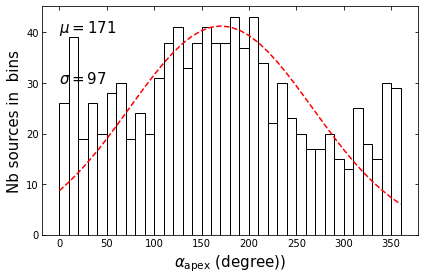

In [28]:
bin_size = 10
bin_array = np.arange(0, 361, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_ra,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_ra.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(0, 40, "$\mu={:.0f}$".format(mu_ra), fontsize=15)
ax.text(0, 30, "$\sigma={:.0f}$".format(std_ra), fontsize=15)

ax.set_xlabel("$\\alpha_{\\rm apex}$ (degree))", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()

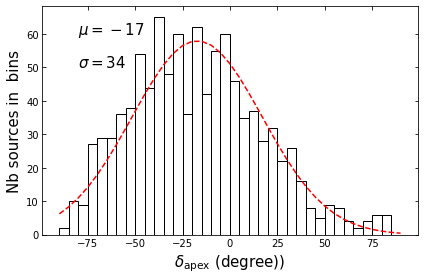

In [29]:
bin_size = 5
bin_array = np.arange(-90, 91, bin_size)

fig, ax = plt.subplots()

ax.hist(resample_dec,
        bins=bin_array,
        color="grey",
        fill=False,
        label="All")

ax.plot(bin_array, rvs_dec.pdf(bin_array)*sample_num*bin_size, "r--")

ax.text(-80, 60, "$\mu={:-.0f}$".format(mu_dec), fontsize=15)
ax.text(-80, 50, "$\sigma={:.0f}$".format(std_dec), fontsize=15)

ax.set_xlabel("$\\delta_{\\rm apex}$ (degree))", fontsize=15)
ax.set_ylabel("Nb sources in  bins", fontsize=15)

plt.tight_layout()